In [1]:
from iris_lmsalpy import hcr2fits, extract_irisL2data
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

# query_text = "https://www.lmsal.com/hek/hcr?cmd=search-events3&outputformat=json&startTime=2017-10-25T04:00&stopTime=2017-10-25T05:00&minnumRasterSteps=320&herEvents=SS&hasData=true&limit=200"
# list_urls = hcr2fits.get_fits(query_text)



The provided file is a raster IRIS Level 2 data file.

Extracting information from file iris_l2_20160114_230409_3630008076_raster_t000_r00000.fits... 

Available data with size Y x X x Wavelength are stored in windows labeled as:

--------------------------------------------------------------------
Index --- Window label --- Y x X x WL --- Spectral range [AA] (band)
--------------------------------------------------------------------
  0 	 C II 1336    	   779x320x374 	   1332.66 - 1337.50  (FUV)
  1 	 Fe XII 1349  	   779x320x245 	   1347.62 - 1350.79  (FUV)
  2 	 O I 1356     	   779x320x340 	   1352.19 - 1356.59  (FUV)
  3 	 Si IV 1394   	   779x320x411 	   1390.87 - 1396.08  (FUV)
  4 	 Si IV 1403   	   779x320x602 	   1398.59 - 1406.23  (FUV)
  5 	 2832         	   779x320x113 	   2831.38 - 2834.23  (NUV)
  6 	 2814         	   779x320x146 	   2812.69 - 2816.38  (NUV)
  7 	 Mg II k 2796 	   779x320x530 	   2793.14 - 2806.61  (NUV)
------------------------------------------------

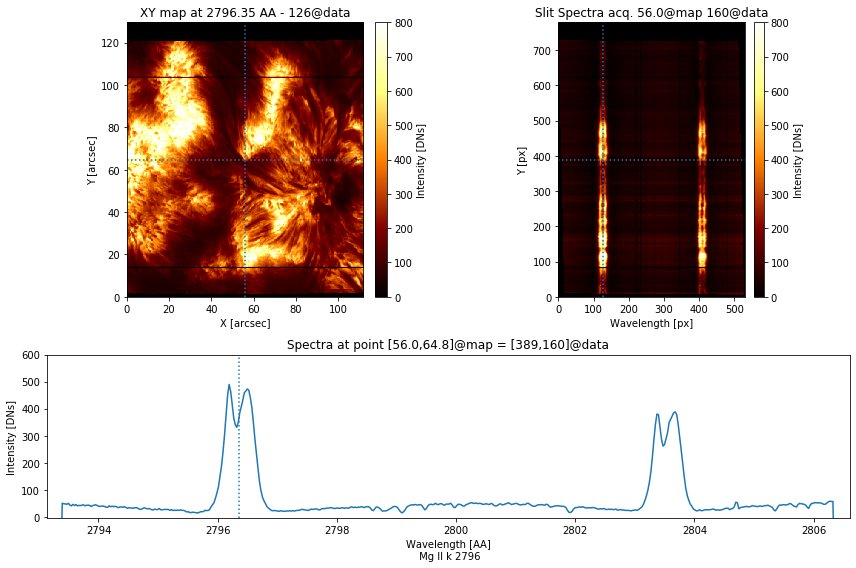

<Figure size 432x288 with 0 Axes>

In [2]:
raster_filename = "iris_l2_20160114_230409_3630008076_raster_t000_r00000.fits"
iris_raster = extract_irisL2data.load(
    raster_filename, window_info=['Mg II k 2796'], verbose=True
)
iris_raster.quick_look()

260 21.0 389 160


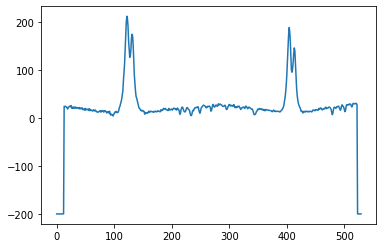

In [170]:
r = iris_raster.raster['Mg II k 2796']
s = r.data.shape
d = r.data[209, 261, :]

delta = 50

# start, number of points
best = [None, 0]
curr = [0, 0]

for i in range(len(d) - 1):
    diff = abs(d[i] - d[i+1])
    if diff < delta:
        curr[1] += 1
    else:
        if best[1] < curr[1]:
            best = curr.copy()
        curr[0], curr[1] = i, 0

best_wl = int(sum(best) / 2)
print(best_wl, d[best_wl], int(s[0]/2), int(s[1]/2))
plt.plot(d)

In [ ]:
plt.imshow(r.data[100:600, :, 50], cmap=r.cmap)
plt.clim([0, 80])
#plt.ylim(100, 600)
plt.axis('off')
plt.savefig("working_image", bbox_inches='tight', pad_inches=0, dpi=166)

In [168]:
a = r.data.copy()[100:600, :, 50]
i = np.unravel_index(a.argmin(), a.shape)
m = a[i[0],i[1]]
mask = a > (m * 0.06)
mask = np.int8(mask)
a.shape
i


(209, 261)

(501, 320, 3)

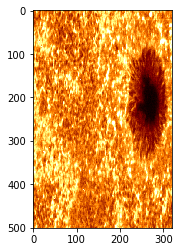

In [166]:
# opens in BGR colorspace, convert to RGB
img = cv2.cvtColor(cv2.imread("working_image.png"), cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

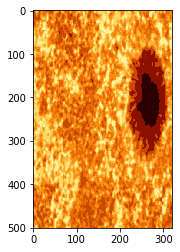

In [81]:
img_orig = img.copy()

# blur image to help smooth out edges
img = cv2.GaussianBlur(img, (7, 7), 0)

# convert to the shape of a vector of pixel values
Z = img.reshape((-1,3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8
ret, label, center = cv2.kmeans(Z, K, None, criteria, 50, cv2.KMEANS_RANDOM_CENTERS)
label = label.flatten()

# Convert back to uint8 and size of original image
center = np.uint8(center)
segmented = center[label.flatten()]
segmented = segmented.reshape((img.shape))

plt.imshow(segmented)

In [82]:
def find_threshold(img, label_name):
    masked_image = np.copy(img)

    # convert to shape of label array
    masked_image = masked_image.reshape((-1, 3))

    # make all pixels without that are not specified label white
    masked_image[~(label == label_name)] = [255, 255, 255]

    # convert back to original shape
    masked_image = masked_image.reshape(img.shape)
    plt.imshow(masked_image)
    plt.show()
    
    # erode then dilate the image to remove noise
    kernel = np.ones((7,7),np.uint8)
    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_OPEN, kernel, iterations=1)
    gray = cv2.cvtColor(masked_image,cv2.COLOR_BGR2GRAY)

    # threshold image by removing all white pixels (not in label) 
    ret, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # create mask by only including large contours
    mask = np.zeros(masked_image.shape[:2], np.uint8)

    for c in contours:
        area = cv2.contourArea(c)
        if area < 100:
            break

        cv2.drawContours(mask, [c], -1, (255), -1)

    # by combining foreground and background, allows specification of background color (white)
    # if don't do, background will be solid black, which is same color as sunspot so problematic
    foreground = cv2.bitwise_or(masked_image, masked_image, mask=mask)
    mask = cv2.bitwise_not(mask)
    background = np.full(masked_image.shape, 255, dtype=np.uint8)
    background = cv2.bitwise_or(background, background, mask=mask)

    combine = cv2.bitwise_or(foreground, background)
    combine_gray = cv2.cvtColor(combine, cv2.COLOR_BGR2GRAY)

    # threshold image again
    ret, thresh = cv2.threshold(combine_gray, 245, 255, cv2.THRESH_BINARY_INV)
    
    return thresh

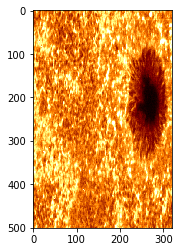

[(1764, 6), (19577, 5), (45329, 0), (64365, 2), (80730, 4), (97396, 3), (120542, 7), (147561, 1)]


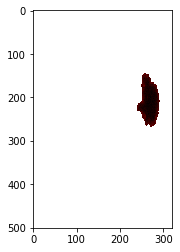

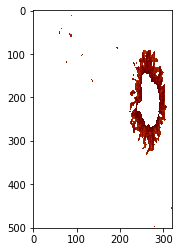

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


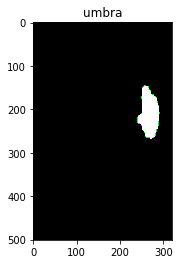

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


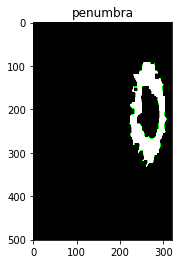

In [100]:
plt.imshow(img_orig)
plt.show()

thresholds = []
# center is a list of colors from the segmentation, sort to find closest to black
# euclidean distance is not ideal for colors, but it's seems okay
center_sort = sorted([(x[0]**2 + x[1]**2 + x[2]**2, i) for i,x in enumerate(center)])
areas = None

print(center_sort)
if center_sort[0][0] > 20000:
    print("No sunspots found")
else:
    sunspot = [find_threshold(img, center_sort[0][1]),
               find_threshold(img, center_sort[1][1])]
    areas = sunspot
    
    for i, t in enumerate(sunspot):

        # use RETR_TREE so inside circle of penumbra gets shown as contour
        cnt, _ = cv2.findContours(t, 
                                cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
        print(t)
                                
        final = cv2.cvtColor(t, cv2.COLOR_GRAY2RGB)
        cv2.drawContours(final, cnt, -1, (0,255,0), 1)

        plt.imshow(final)
        plt.title(['umbra', 'penumbra'][i])
        plt.show()

    

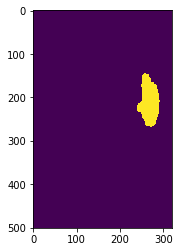

In [153]:
u = areas[0]
plt.imshow(u)
u_pixels = []
a = r.data.copy()[100:600, :, :]
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        if u[i,j]:
            u_pixels.append(a[i,j,:])
u_pixels = np.array(u_pixels)

In [154]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=60
)
y_km = km.fit_predict(u_pixels)

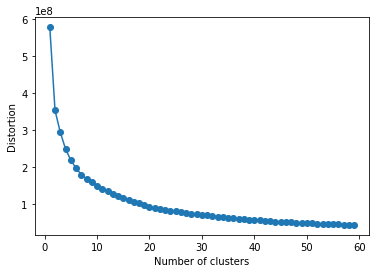

In [143]:
distortions = []
for i in range(1, 60):
    km = KMeans(
        n_clusters=i
    )
    km.fit(u_pixels)
    distortions.append(km.inertia_)
    print(i)

# plot
plt.plot(range(1, 60), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [162]:
np.set_printoptions(threshold=np.inf)
print(y_km)
print(km.cluster_centers_)
np.set_printoptions(threshold=1000)

[ 6 50 50 50 50 50 50 50 50 50 50  6 50 50 50 50 50 50 50 50 50  6 50 50
 50 50 50 50 50 50 50 50 50  6  6  6 50 50 50 50 50 50 50 50 50 50 50  6
  6  6 50 50 50 50 50 50 50 50 50 50 50  6  6  6 50 50 50 50 50 50 50 50
 50 50 50 50 48 11 11 50 50 50 50 50 50 50 50 50 50 50 50 50 46 48 11 11
 11 11 11 11 50 50 50 50 50 50 50 50 50 46 48 11 11 11 11 11 11 11 11 11
 50 50 50 50 50 50 50 46 48 11 11 11 11 11 11 11 11 11 26 26 11 11 50 50
 50 50 50 46 48 11 11 11 11 11 11 11 11 26 26 26 26 11 11 11 11 11 11 11
 56 48 11 11 11 11 11 11 11 26 26 26 26 26 11 11 11 11 11 11 11 56 48 11
 11 11 11 11 11 11 26 26 26 26 11 11 11 11 11 48 48 48 48 48 11 11 11 11
 11 11 11 26 26 26 26 11 11 11 11 11 48 48 48 48 18 48 11 11 11 11 11 11
 26 26 26 26 11 11 11 11 26 18 18 18 18 18 48 11 11 11 11 11 26 26 26 26
 26 11 11 11 26 48 56  9 30 18 56 18 48 11 11 11 11 11 26 26 26 26 26 26
 26 26 46  9  9 30 30 56 18 48 11 11 11 11 26 26 26 26 26 26 26 26  1 56
  9  9  9 30 56 56 48 26 26 47 11 11 26 26 26 26 26

[[-200.        -200.        -200.        -200.        -200.
  -200.        -200.        -200.        -200.        -200.
    10.206024    10.217072    10.0219755    9.777472     9.758241
     9.453297     9.456043     9.178573     8.777472     8.071429
     8.376373     9.184065     9.101648     9.326924     9.406594
     9.659342     9.151098     9.054945     8.285715     8.274725
     8.664835     8.747252     8.774725     8.818681     8.821428
     8.934066     8.642857     8.186813     8.958792     8.285715
     8.07967      7.9835157    7.813187     8.04945      7.947802
     7.821428     7.8598895    8.401099     7.4395604    7.590659
     8.131868     7.6758237    7.59066      7.7499995    7.335165
     7.4010983    7.260989     7.2115383    7.28022      6.8324175
     6.9258246    6.574176     6.2225275    6.7527475    6.612637
     6.543956     6.370879     6.4038463    6.516484     6.2060432
     5.821429     5.340659     5.052198     5.5631866    6.164835
     5.494506     5.

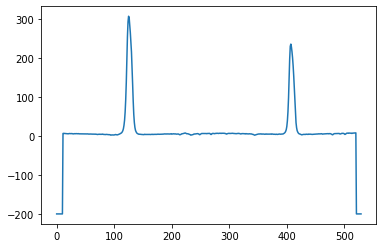

In [173]:
u_pixels[y_km==0][0]
plt.plot(km.cluster_centers_[3])

In [129]:
u_pixels

[array([-200.  , -200.  , -200.  , -200.  , -200.  , -200.  , -200.  ,
        -200.  , -200.  , -200.  , -200.  , -200.  , -200.  ,   17.25,
          18.5 ,   17.  ,   14.5 ,   17.  ,   16.  ,   16.  ,   14.5 ,
          18.  ,   16.  ,   16.25,   15.5 ,   16.  ,   17.25,   16.25,
          16.75,   15.5 ,   16.25,   14.75,   16.75,   17.5 ,   15.25,
          13.25,   14.75,   14.75,   14.25,   16.  ,   15.75,   18.25,
          16.5 ,   13.75,   15.5 ,   13.75,   14.25,   15.25,   13.25,
          14.  ,   13.5 ,   12.75,   11.25,   11.25,   13.25,   11.75,
          12.  ,   14.25,   12.  ,   12.75,   10.75,   11.25,    8.75,
          10.75,   10.  ,    9.75,   10.75,   10.25,    9.  ,    8.5 ,
          10.75,    9.5 ,    8.75,    9.75,   10.75,    8.25,    8.  ,
           6.25,    8.75,   10.  ,   11.25,    8.75,    9.  ,    8.  ,
           7.25,    8.5 ,    7.75,    6.25,    6.25,    7.25,    7.25,
           6.  ,    5.75,    5.5 ,    7.25,    5.5 ,    3.5 ,    6.25,
      

In [145]:
import os
os.remove("working_image.png")

In [19]:
del iris_raster
del r, d

NameError: name 'r' is not defined